# **Using VGG 16 Pre-Trained Model for Predicting traffic Confusion Using Image Analysis :**
## **1. At first, I had a dataset of 370 images calssified as :**
> High Traffic --> 99 images

> Medium Traffic --> 171 images

> Low Traffic --> 100 images
### **with a total of 370 Images.**


## **2. The first step of preparing the dataset for the model was applying some preprocessing techniques on it so that it matches the model requirments for the input, so I made changes like normalizing pixel size and reducing image resolution and making all images have the same resolution for fixed input size.**
## **3. But still this was too small dataset for a model with a very high complexity and trained on large datsets like ImageNet and having millions of parameters like VGG16, so I had to apply Augmentation with ratios that make all classes have close number of images so that the model won't be biased for a certain class to increase the diversity of my dataset by increasing it's size and make the model more generalized . :**
> High Traffic --> 735 images

> Low Trafiic --> 763 images

> Medium Traffic --> 742 images
### **with a total of 2240 images.**

## **4. After that I splitted the images into two seperate folders, Traffic_Modified that was for training and validation data:**
> High Traffic --> 615 images

> Low Trafiic --> 630 images

> Medium Traffic --> 625 images
### **with a total of 1870 Images.**

Splitted on two :
Training --> 1496 images ||
Validation --> 374 images

## **5. Traffic_Test Folder that was for testing data:**
> High Traffic --> 120

> Low Trafiic --> 133

> Medium Traffic --> 117
### **with a total of 370 test Images.**

## **6. After That I started training the model with freezing the first 15 layers of the model 16 layers.**

## **7. then unfreezing the first 15 layers and fine tuninning them with the dataset.**

## **8. then visualizing the model performance through some plots.**



### **Importing the used libraries :**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, save_img
from sklearn.model_selection import train_test_split

### **Applying Preprocessing Techniques to each image once then applying Augmentation then saving both in the desired directory :**

In [ ]:
data_dir = r"C:\Users\hp\Desktop\ML_Project\VGG16\Traffic_Labeled"
output_dir = r"C:\Users\hp\Desktop\ML_Project\VGG16\Traffic_Modified"

os.makedirs(output_dir, exist_ok=True)

datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,  # Random shear transformations
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'  # Strategy for filling in newly created pixels during transformations
)

# Get the class names (subdirectories in data_dir)
class_names = os.listdir(data_dir)

# Process each class and augment its images
for class_name in class_names:
    class_dir = os.path.join(data_dir, class_name)
    if os.path.isdir(class_dir):
        # Create a directory to save the preprocessed images and augmentations for this class
        class_output_dir = os.path.join(output_dir, class_name)
        os.makedirs(class_output_dir, exist_ok=True)

        # List all the images in this class
        images = [f for f in os.listdir(class_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]

        for image_name in images:
            # Load and preprocess the image
            image_path = os.path.join(class_dir, image_name)
            img = load_img(image_path, target_size=(224, 224))  # Resize to 224x224 (VGG16 input size)
            img_array = img_to_array(img)  # Convert image to array

            # Normalize the image
            img_array /= 255.0  # Normalize pixel values to [0, 1]

            # Save the preprocessed image (one copy per original image)
            preprocessed_path = os.path.join(class_output_dir, f"preprocessed_{image_name}")
            save_img(preprocessed_path, img_array)  # Save the preprocessed image

            # Augment and save 5 augmented versions of each image
            img_array = img_array.reshape((1,) + img_array.shape)  # Reshape for the ImageDataGenerator
            i = 0
            for batch in datagen.flow(img_array, batch_size=1, save_to_dir=class_output_dir, save_prefix='aug',
                                      save_format='jpeg'):
                i += 1
                if i >= 5:  # Generate 5 augmented images per original image
                    break

print("Preprocessing and augmentation complete!")


### **Retreiving the Preprocessed and Augmented data from the path that it is saved at:**

In [ ]:
# Paths and parameters
train_dir = r"C:\Users\hp\Desktop\ML_Project\VGG16\Traffic_Modified"
test_dir = r"C:\Users\hp\Desktop\ML_Project\VGG16\Traffic_Test"
batch_size = 16
img_size = (224, 224)  # Updated input size to 224x224

# Data generators
datagen = ImageDataGenerator(validation_split=0.2, rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_directory(
    train_dir,
    target_size=img_size,  # Updated input size
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    train_dir,
    target_size=img_size,  # Updated input size
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,  # Updated input size
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Shuffle set to False to align predictions with true labels
)

### **Training and Fine Tunning the VGG16 model :**

In [ ]:
# Load VGG16 pre-trained model without the top (fully connected) layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))  # Updated input shape


# Freeze initial layers
for layer in base_model.layers[:15]:  # Freeze the first 15 layers
    layer.trainable = False

# Build the model by adding custom layers on top of VGG16
model = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer='l2'),
    Dropout(0.5),
    Dense(train_gen.num_classes, activation='softmax')
])

# Compile the model with a low learning rate for fine-tuning
model.compile(
    optimizer=Adam(learning_rate=1e-5),  # Lower learning rate for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Unfreeze the last few layers of the base model
for layer in base_model.layers[15:]:  # Unfreeze the last few layers
    layer.trainable = True

# Callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)

# Train the model with data augmentation and callbacks
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5,
    batch_size=batch_size,
    verbose=1,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_gen, verbose=1)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Confusion Matrix
y_true = test_gen.classes  # True labels
y_pred = np.argmax(model.predict(test_gen), axis=1)  # Predicted labels

### **Visualizing the performance of the model through some plots :**

In [ ]:
# Create and display confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(test_gen.class_indices.keys()))
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=list(test_gen.class_indices.keys())))

# Visualize the results
def plot_metrics(history, test_accuracy):
    epochs = range(1, len(history.history['accuracy']) + 1)

    # Plot accuracy
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['accuracy'], 'b', label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], 'r', label='Validation Accuracy')
    plt.axhline(test_accuracy, color='g', linestyle='--', label='Test Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['loss'], 'b', label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], 'r', label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_metrics(history, test_accuracy)

# Save the trained model
model.save("vgg16_fine_tuned_model.h5")
print("Model training complete and saved as 'vgg16_fine_tuned_model.h5'")

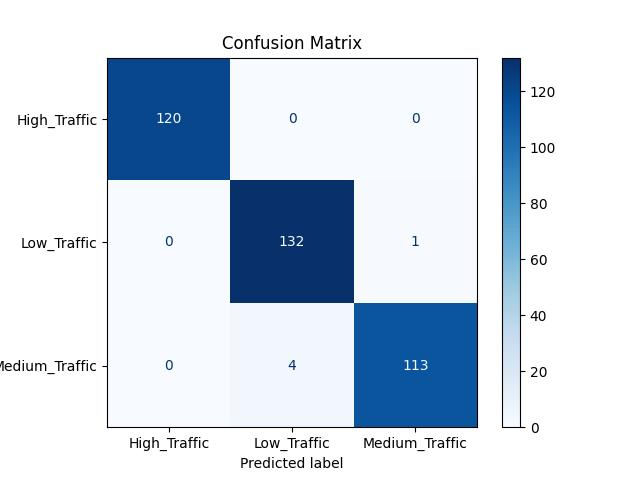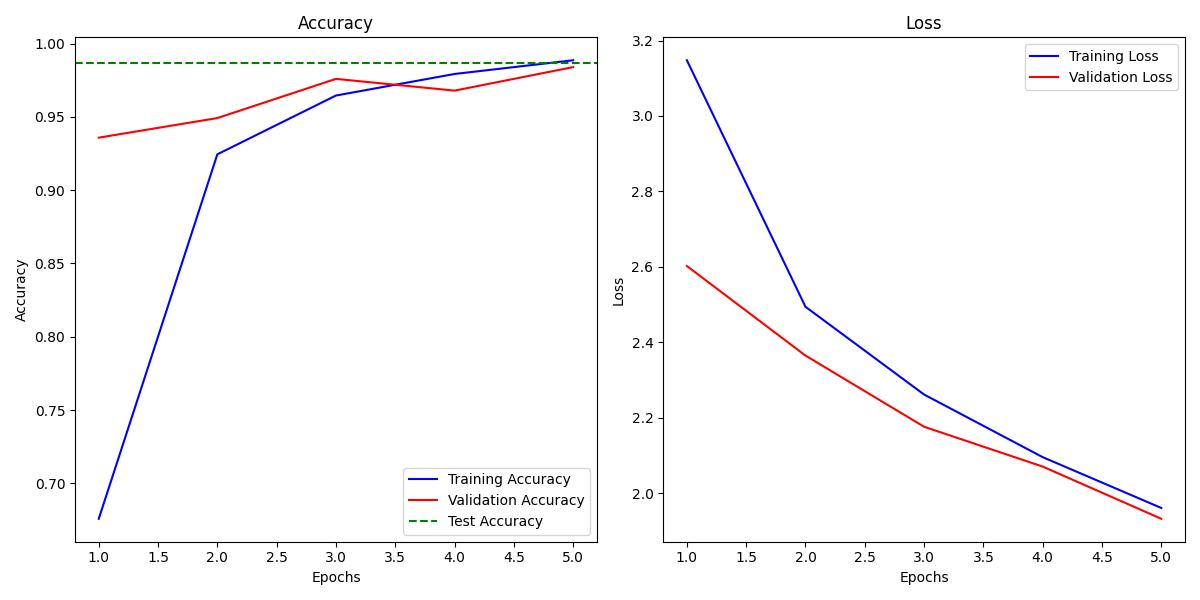